<a href="https://colab.research.google.com/github/gabegraves/Battery-Clustering/blob/main/SR4_Battery_k_means_%26_SVC_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import required libraries/choose style

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
! pip install k-means-constrained
# ! pip uninstall ortools
! pip install k-means-constrained>=0.7.2
! pip install ortools==9.3.10497
import ortools
import ortools.graph.pywrapgraph
from k_means_constrained import KMeansConstrained
from matplotlib import style
import seaborn as sns
import os
from pathlib import Path
style.use('ggplot')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 561 kB 4.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 16.0 MB 42.7 MB/s 
  Created wheel for k-means-constrained: filename=k_means_constrained-0.7.0-cp37-cp37m-linux_x86_64.whl size=1419588 sha256=2e77a36745a3bc8d1e1a0402fb25ca385e1bb1daa0a6fe48c8f61322257da19a
  Stored in directory: /root/.cache/pip/wheels/97/2e/70/c473dfd41bc709dd3c2a89ae09d345a5ffb77d1906a2a77176
Successfully built k-means-constrained
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.5 MB 5.4 MB/s 
  Attempting uninstall: ortools
    Found existing installation: ortools 9.4.1874
    Uninstalling ortools-9.4.1874:
      Successfully uninstalled ortools-9.4.1874


# Read data from csv to pandas dataframe

In [ ]:
from google.colab import files
uploaded = files.upload()
for key, val in uploaded.items():
  filename = key
print(filename)
df = pd.read_excel(filename)
df.head()

Saving Energy Assurance Cell Characterization.xlsx to Energy Assurance Cell Characterization.xlsx
Energy Assurance Cell Characterization.xlsx


,Sample,Cell S/N,AC Impedance (Ω) after first Charge,0.2C Capacity Cycle 1,0.2C Capacity Cycle 2,0.2C Capacity Cycle 3,Voltage (End of Charge),Voltage (72 hrs),Residual Capacity (Ah),Recoverable Capacity (Ah),AC Impedance (Ω),AC Impendance (Final - Initial) (Ω)
0,1,INR-18650-M35A MOLICEL 09 2L806 01,0.024495,3.4505,3.4475,3.4528,4.1902,4.1400,3.4117,3.4190,0.025894,0.001399
1,2,INR-18650-M35A MOLICEL 09 2L806 01,0.024573,3.3872,3.4241,3.4312,4.1933,4.1437,3.3909,3.3996,0.026211,0.001638
2,3,INR-18650-M35A MOLICEL 09 2L806 01,0.024622,3.3893,3.3770,3.3878,4.1781,4.1334,3.3536,3.3627,0.026668,0.002046
3,4,INR-18650-M35A MOLICEL 09 2L806 01,0.024739,3.4306,3.4398,3.4340,4.1930,4.1418,3.4033,3.4178,0.026715,0.001976
4,5,INR-18650-M35A MOLICEL 09 2L806 01,0.024627,3.4124,3.4305,3.4353,4.1930,4.1427,3.3969,3.4048,0.026544,0.001917


In [ ]:
df.drop(['Cell S/N', 'AC Impedance (Ω) after first Charge', '0.2C Capacity Cycle 1', '0.2C Capacity Cycle 2', '0.2C Capacity Cycle 3', 'Voltage (72 hrs) ', 'Residual Capacity (Ah)'], axis=1, inplace=True)
df.head()

,Sample,Voltage (End of Charge),Recoverable Capacity (Ah),AC Impedance (Ω),AC Impendance (Final - Initial) (Ω)
0,1,4.1902,3.4190,0.025894,0.001399
1,2,4.1933,3.3996,0.026211,0.001638
2,3,4.1781,3.3627,0.026668,0.002046
3,4,4.1930,3.4178,0.026715,0.001976
4,5,4.1930,3.4048,0.026544,0.001917


Rename the columns and drop row 0

In [ ]:
df.rename(columns={}, inplace = True)
df

,Sample,Voltage (End of Charge),Recoverable Capacity (Ah),AC Impedance (Ω),AC Impendance (Final - Initial) (Ω)
0,1,4.1902,3.4190,0.025894,0.001399
1,2,4.1933,3.3996,0.026211,0.001638
2,3,4.1781,3.3627,0.026668,0.002046
3,4,4.1930,3.4178,0.026715,0.001976
4,5,4.1930,3.4048,0.026544,0.001917
...,...,...,...,...,...
1979,1980,4.1939,3.4219,0.026405,0.001460
1980,1981,4.1933,3.4333,0.026397,0.001404
1981,1982,4.1933,3.3739,0.026177,0.001211
1982,1983,4.1936,3.4023,0.026720,0.001605


# Describe column statistics and create a pair plot

In [ ]:
df = df.dropna().astype(float)
df.describe(include = 'all')

,Sample,Voltage (End of Charge),Recoverable Capacity (Ah),AC Impedance (Ω),AC Impendance (Final - Initial) (Ω)
count,1984.000000,1984.000000,1984.000000,1984.000000,1984.000000
mean,992.500000,4.190454,3.386724,0.026678,0.001767
std,572.875786,0.007596,0.041615,0.007661,0.007652
min,1.000000,4.046000,1.849600,0.002696,-0.022341
25%,496.750000,4.192200,3.374675,0.026209,0.001348
50%,992.500000,4.193000,3.387650,0.026430,0.001517
75%,1488.250000,4.193300,3.404000,0.026645,0.001688
max,1984.000000,4.198900,3.440100,0.268960,0.243687


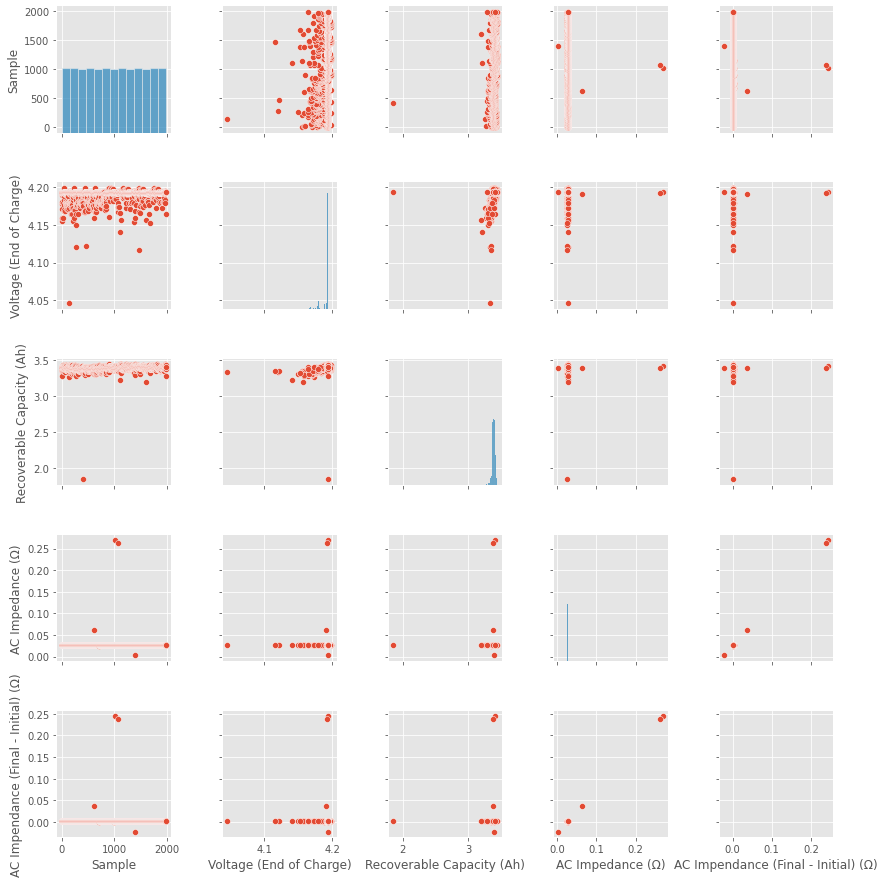

In [ ]:
sns.pairplot(df)

# Perform K means Clustering

In [ ]:
#import sklearn cluster library and pyplot
import sklearn.cluster as cluster
import matplotlib.pyplot as plt

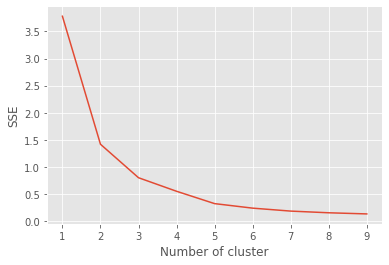

In [ ]:
#create sum of squared errors dictionary, determine value of k
sse = {}
for k in range(1, 10):
  kmeans = cluster.KMeans(n_clusters = k, init = 'k-means++')
  kmeans = kmeans.fit(df[['Voltage (End of Charge)', 'Recoverable Capacity (Ah)', 'AC Impedance (Ω)', 'AC Impendance (Final - Initial) (Ω)']])
  sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [ ]:
clf = KMeansConstrained(
     n_clusters=31,
     size_min=64,
     size_max=64,
     random_state=0
)
clf.fit_predict(df[['Voltage (End of Charge)', 'Recoverable Capacity (Ah)', 'AC Impedance (Ω)', 'AC Impendance (Final - Initial) (Ω)']])
print(clf.cluster_centers_)
print(clf.labels_)

NameError: ignored

In [ ]:
#using six variables and four clusters given SSE plot from the elbow method
#elbow method = select k for which the subsequent k values descrease in a linear fashion
kmeans = cluster.KMeans(n_clusters = 18, init = 'k-means++')
kmeans = kmeans.fit(df[['Voltage (End of Charge)', 'Recoverable Capacity (Ah)', 'AC Impedance (Ω)', 'AC Impendance (Final - Initial) (Ω)']])

In [ ]:
#create array of center of clusters
clf.cluster_centers_

array([[4.19335781e+00, 3.39851250e+00, 2.64476875e-02, 1.57020312e-03],
       [4.16481094e+00, 3.29617500e+00, 3.38119375e-02, 8.89907812e-03],
       [4.19294687e+00, 3.38068750e+00, 2.65218281e-02, 1.54973437e-03],
       [4.19304375e+00, 3.41641719e+00, 2.63997813e-02, 1.50701563e-03],
       [4.19355313e+00, 3.41337812e+00, 2.63977344e-02, 1.53484375e-03],
       [4.19343906e+00, 3.38701563e+00, 2.64568125e-02, 1.53350000e-03],
       [4.19232656e+00, 3.36132969e+00, 2.65299531e-02, 1.50695312e-03],
       [4.19337656e+00, 3.43044687e+00, 2.62945469e-02, 1.45626563e-03],
       [4.19298594e+00, 3.37304062e+00, 2.64830937e-02, 1.52529688e-03],
       [4.19276406e+00, 3.38909219e+00, 2.64826094e-02, 1.55214063e-03],
       [4.17871094e+00, 3.36368750e+00, 2.63304687e-02, 1.53871875e-03],
       [4.19095156e+00, 3.39965312e+00, 2.61075937e-02, 1.17023437e-03],
       [4.18067344e+00, 3.34757500e+00, 2.63528750e-02, 1.44873437e-03],
       [4.19122813e+00, 3.41082187e+00, 2.64484844e

Attatch clusters to orginal data

In [ ]:
df['Clusters'] = clf.labels_
df.head()

,Sample,Voltage (End of Charge),Recoverable Capacity (Ah),AC Impedance (Ω),AC Impendance (Final - Initial) (Ω),Clusters
0,1.0,4.1902,3.4190,0.025894,0.001399,19
1,2.0,4.1933,3.3996,0.026211,0.001638,11
2,3.0,4.1781,3.3627,0.026668,0.002046,10
3,4.0,4.1930,3.4178,0.026715,0.001976,3
4,5.0,4.1930,3.4048,0.026544,0.001917,23


Determine amount of cells belonging to certain clusters

In [ ]:
df['Clusters'].value_counts()

19    64
14    64
6     64
24    64
28    64
27    64
2     64
21    64
22    64
12    64
29    64
13    64
16    64
15    64
17    64
26    64
11    64
7     64
9     64
5     64
20    64
30    64
25    64
18    64
1     64
4     64
0     64
23    64
3     64
10    64
8     64
Name: Clusters, dtype: int64

<Figure size 432x288 with 0 Axes>

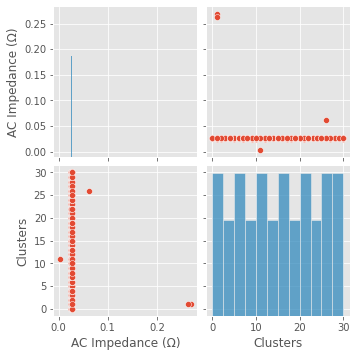

In [ ]:

#show final impedance vs cluster
plt.figure()

sns.pairplot(df[['AC Impedance (Ω)', 'Clusters']])
plt.show()

In [ ]:
avg_imp = []
avg_delt_imp = []
for j in range(31):
  sum_imp = 0
  sum_delt_imp = 0
  for i in range(len(df.index)):
    if df['Clusters'][i] == j:
      sum_imp += df['AC Impedance (Ω)'][i] 
      sum_delt_imp += df['AC Impendance (Final - Initial) (Ω)'][i]
  avg_imp.append((sum_imp/64))
  avg_delt_imp.append((sum_delt_imp/64))
print(avg_imp)
print(avg_delt_imp)

In [ ]:
df2 = pd.DataFrame()
df2['Average Impedance'] = avg_imp
df2['Average Delta Impedance'] = avg_delt_imp
df2.head()

Export the data with clusters to excel

In [ ]:
# #either input file location and file name or just output filename
# outfilename = 'SR4KmeansBResults1.xlsx'
# #outfilepath = Path(r'C:\Users\gabeg\OneDrive\Documents\batteryKMeansResults\kmeansBResults1.xlsx')
# #filepath.parent.mkdir(parents = True, exist_ok = True)
# df.to_excel(outfilename, index = False, header = True)
# files.download(outfilename)

In [ ]:
# !pip install xlsxwriter
import xlsxwriter
outfilename = 'SR4KmeansBResults.xlsx'
outfilepath = Path(r'C:\Users\gabeg\OneDrive\Documents\SR4KmeansBResults.xlsx')

# Create a Pandas Excel writer using XlsxWriter as the engine.
# writer = pd.ExcelWriter(outfilepath, engine='xlsxwriter')

# Write each dataframe to a different worksheet.

with pd.ExcelWriter('SR4KmeansBResults.xlsx') as writer:
   
    # use to_excel function and specify the sheet_name and index
    # to store the dataframe in specified sheet
    df.to_excel(writer, sheet_name="Sheet1", index=False, header = True)
    df2.to_excel(writer, sheet_name="Sheet2", index=False)
    files.download(writer)

# SVC Algorithm